In [5]:
!pip install xlsxwriter python-docx pandas

以下將word檔輸出一個excel，有編號、證物名稱、採證位置、鑑定結果、鑑定結論、其他實驗實比對及其他一般資訊

In [1]:
from zipfile import ZipFile
import os
import glob
import re
import pandas as pd
from xml.etree import ElementTree as ET

# Path to the folder containing docx files
docx_folder = r"C:\Users\tcc07\Desktop\python1121\期末專案\DNA鑑定書 範例檔案"  # Replace with the path to your folder

# Function to extract text from XML
def extract_text_from_xml(xml_content):
    """ Extract text from an XML string. """
    tree = ET.fromstring(xml_content)
    namespaces = {'w': 'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}
    paragraphs = tree.findall('.//w:p', namespaces)
    return '\n'.join([''.join(node.itertext()) for node in paragraphs])

def extract_text_from_docx(docx_path):
    """ Extracts text from a docx file's XML. """
    # Unzip the docx file
    with ZipFile(docx_path, 'r') as zip_ref:
        zip_ref.extractall(zip_folder)

    # Read and parse the XML files
    extracted_texts = []
    for root, _, files in os.walk(zip_folder):
        for file in files:
            if file.endswith('.xml'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as file:
                    xml_content = file.read()
                    text = extract_text_from_xml(xml_content)
                    extracted_texts.append(text)
    return '\n'.join(extracted_texts)

def extract_specific_evidence_info(text):
    """ Extracts evidence information between the first occurrence of '送檢證物' and '鑑定結果'. """
    start = text.find('送檢證物')
    end = text.find('鑑定結果', start)
    relevant_text = text[start:end] if start != -1 and end != -1 else ""

    # Adjusting regex pattern to capture evidence name until the newline character
    pattern = r'([^\（\n]*)（編號(.*?)，(.*?)）'
    matches = re.findall(pattern, relevant_text)
    return [(match[1], match[0].strip(), match[2]) for match in matches]

def extract_results_or_conclusion(text, start_marker, end_markers, evidence_number, evidence_name):
    """ Extracts a section containing the evidence number and name between specified markers with flexibility. """
    start_index = text.find(start_marker)
    end_index = min([text.find(marker, start_index) for marker in end_markers if text.find(marker, start_index) != -1] + [len(text)])

    if start_index == -1 or end_index == -1 or end_index <= start_index:
        return None

    section = text[start_index + len(start_marker):end_index]
    evidence_number_pattern = rf'[^A-Za-z0-9-]+\s*{evidence_number}\s*[^A-Za-z0-9-]+'
    evidence_name_pattern = rf'{re.escape(evidence_name)}'

    evidence_number_match = re.search(evidence_number_pattern, section)
    evidence_name_match = re.search(evidence_name_pattern, section)

    if evidence_number_match and evidence_name_match:
        # Find the paragraph that contains both evidence number and name
        paragraphs = section.split('\n')
        for paragraph in paragraphs:
            if evidence_number in paragraph and evidence_name in paragraph:
                return paragraph
    return None

def extract_additional_info_adjusted(text):
    """ Extracts additional information with adjusted patterns. """
    patterns = {
        '實驗室案件編號': r'實驗室案件編號：([^\n]+)',
        '發文日期': r'發文日期：([^\n]+)',
        '發文字號': r'發文字號：([^\n]+)',
        '案號': r'案號：([^\n]+)',
        '案由': r'案由：([^\n]+)',
        '轄區單位': r'轄區單位：([^\n]+)',
        '來文日期': r'來文日期：([^\n]+)',
        '來文字號': r'來文字號：([^\n]+)',
        '承辦人': r'承\s+辦\s+人：([^\n]+)',
        '報告簽署人': r'報告簽署人：([^\n]+)'
    }

    additional_info = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, text)
        additional_info[key] = match.group(1).strip() if match else None

    return additional_info

# Create a folder for unzipping
zip_folder = 'unzipped_word_files'
os.makedirs(zip_folder, exist_ok=True)

# Get all docx files in the folder
docx_files = glob.glob(os.path.join(docx_folder, '*.docx'))

# Extract text from each docx file
extracted_texts = []
for docx_file in docx_files:
    text = extract_text_from_docx(docx_file)
    extracted_texts.append(text)

# Clean up the temporary unzipped folder
os.system(f"rm -rf {zip_folder}")

# Update the function to include the new criteria for extracting "鑑定結果" and "鑑定結論"
def map_evidence_data(texts):
    complete_mapped_data = []
    for text in texts:
        additional_info = extract_additional_info_adjusted(text)
        evidence_info = extract_specific_evidence_info(text)
        for evidence in evidence_info:
            evidence_number, evidence_name, _ = evidence
            jieguo = extract_results_or_conclusion(text, '鑑定結果：', ['鑑定結果表', '鑑定結論：'], evidence_number, evidence_name)
            jielun = extract_results_or_conclusion(text, '鑑定結論：', ['經資料庫關聯其他實驗室案件', '備註：'], evidence_number, evidence_name)
            other_lab_related = extract_results_or_conclusion(text,'經資料庫關聯其他實驗室案件：', '備註：', evidence_number, evidence_name)
            complete_mapped_data.append({
                **additional_info,
                **dict(zip(['證物編號', '證物名稱', '採證位置'], evidence)),
                '鑑定結果': jieguo,
                '鑑定結論': jielun,
                '關聯其他實驗室案件': other_lab_related
            })
    return complete_mapped_data

# Mapping the complete information with flexible extraction criteria
mapped_data = map_evidence_data(extracted_texts)

# Creating a DataFrame with the complete mapped information
text_df = pd.DataFrame(mapped_data)

#「鑑定結果」和「鑑定結論」的N/A值填上「無」
text_df[['鑑定結果', '鑑定結論']] = text_df[['鑑定結果', '鑑定結論']].fillna('無')

#依照「鑑定結果」和「鑑定結論」的內容，過濾其中文字判讀「檢出情形」

#未檢出
text_df.loc[text_df['鑑定結果'].str.contains("未檢測。", na=False), '檢出情形'] = "未檢測"
text_df.loc[text_df['鑑定結果'].str.contains("未檢出DNA量", na=False), '檢出情形'] = "未檢出（量無）"
text_df.loc[text_df['鑑定結果'].str.contains("DNA量微|DNA均量微", na=False), '檢出情形'] = "未檢出（量微）"
text_df.loc[text_df['鑑定結果'].str.contains("未檢出DNA-STR型別", na=False), '檢出情形'] = "未檢出（無型別）"
text_df.loc[text_df['鑑定結果'].str.contains("未檢出足資比對DNA-STR型別", na=False), '檢出情形'] = "未檢出（不足資）"
text_df.loc[text_df['鑑定結果'].str.contains("因無比對對象，故暫未研判", na=False), '檢出情形'] = "混合型暫未研判"
text_df.loc[text_df['鑑定結果'].str.contains("惟暫未進行DNA-STR型別檢測", na=False), '檢出情形'] = "暫未進行DNA-STR型別檢測"

#XV,V,XR,R
text_df.loc[text_df['鑑定結論'].str.contains(r'與被害人.*相符.*(?!.*機率預估為)', na=False), '檢出情形'] = '被害人（未出機率）'
text_df.loc[text_df['鑑定結論'].str.contains(r'與被害人.*相符.*機率預估為.*', na=False), '檢出情形'] = '被害人（有出機率）'
text_df.loc[text_df['鑑定結論'].str.contains(r'與關係人.*相符.*(?!.*機率預估為)', na=False), '檢出情形'] = '關係人（未出機率）'
text_df.loc[text_df['鑑定結論'].str.contains(r'與關係人.*相符.*機率預估為.*', na=False), '檢出情形'] = '關係人（有出機率）'

#N
text_df.loc[text_df['鑑定結論'].str.contains(r'(?!.*其餘外來型別)(.*未比中強制建檔對象|.*未發現相符|為["同一"]?男?女?性。)', na=False), '檢出情形'] = '未比中強制建檔對象'
#有可能是LO，但後面的LO條件設定好，把N的結果覆蓋過去

#S
text_df.loc[text_df['鑑定結論'].str.contains(r'與涉嫌人.*相符|送檢涉嫌人.*與.*相符', na=False), '檢出情形'] = '涉嫌人'

#SL清案件的鑑定結論內容尚未納入程式碼中

#SP
text_df.loc[text_df['鑑定結論'].str.contains(r'建檔案」涉嫌人.*相符', na=False), '檢出情形'] = '強制建檔對象'

#L
text_df.loc[text_df['鑑定結論'].str.contains(r'與.*刑事案件證物採驗紀錄表送檢.*相符|與下列案件送檢.*相符', na=False), '檢出情形'] = '本局資料庫關聯'

#LO
text_df.loc[text_df['關聯其他實驗室案件'].notnull(), '檢出情形'] = "其他實驗室關聯"
#有可能是排除…證物後其餘型別，應重新設計語法！

#混合型（V,R,S,證物型別,N）
text_df.loc[text_df['鑑定結論'].str.contains("混合型別", na=False), '檢出情形'] = "混合型"
        
# Save the complete DataFrame to an Excel file
final_output_excel = 'extracted_text.xlsx'
text_df.to_excel(final_output_excel, index=False)

text_df


C:\Users\tcc07\AppData\Local\Temp\ipykernel_22160\121915841.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '未檢測' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  text_df.loc[text_df['鑑定結果'].str.contains("未檢測。", na=False), '檢出情形'] = "未檢測"
C:\Users\tcc07\AppData\Local\Temp\ipykernel_22160\121915841.py:156: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  text_df.loc[text_df['鑑定結論'].str.contains(r'(?!.*其餘外來型別)(.*未比中強制建檔對象|.*未發現相符|為["同一"]?男?女?性。)', na=False), '檢出情形'] = '未比中強制建檔對象'


,實驗室案件編號,發文日期,發文字號,案號,案由,轄區單位,來文日期,來文字號,承辦人,報告簽署人,證物編號,證物名稱,採證位置,鑑定結果,鑑定結論,關聯其他實驗室案件,檢出情形
0,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,1,棉棒,採自編號1疑似手指虎握把,編號1棉棒經抽取DNA檢測結果，未檢出足資比對DNA-STR型別。,無,None,未檢出（不足資）
1,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,2,棉棒,採自編號2疑似手指虎握把,無,本案編號2棉棒DNA為男性，與涉嫌人我很壞（66年12月6日、L115351534）DNA-...,None,涉嫌人
2,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,4-3,棉棒,採自2樓走道上證物編號4電風扇底座疑似汗漬處,編號4-3棉棒經抽取DNA檢測，人類DNA定量結果，DNA量微，未進行DNA-STR型別檢測。,無,None,未檢出（量微）
3,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,4-6-1,棉棒,採自2樓走道上證物編號4電風扇證物編號4-6斑跡處,編號4-6-1、27-1、B5、D3-7-1棉棒以Kastle-Meyer血跡反應檢測法檢測...,無,None,未檢出（量微）
4,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,27-1,棉棒,採自2樓走道北側牆壁上證物編號27掌紋斑跡邊緣處,編號4-6-1、27-1、B5、D3-7-1棉棒以Kastle-Meyer血跡反應檢測法檢測...,無,None,未檢出（量微）
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,4-14,菸蒂,採自客廳桌面,編號4-14、4-15、4-16、4-17、4-18菸蒂，均未檢測。,無,None,未檢測
61,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,4-15,菸蒂,採自客廳桌面,編號4-14、4-15、4-16、4-17、4-18菸蒂，均未檢測。,無,None,未檢測
62,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,4-16,菸蒂,採自客廳桌面,編號4-14、4-15、4-16、4-17、4-18菸蒂，均未檢測。,無,None,未檢測
63,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,4-17,菸蒂,採自客廳桌面,編號4-14、4-15、4-16、4-17、4-18菸蒂，均未檢測。,無,None,未檢測


#輸出鑑定結果表

In [2]:
import os
import pandas as pd
import numpy as np
from docx import Document
import re

# Extract tables again as the code execution state was reset
def extract_tables(document):
    tables = []
    for table in document.tables:
        df = pd.DataFrame([[cell.text for cell in row.cells] for row in table.rows])
        tables.append(df)
    return tables

def rearrange_table_data_specific_columns(table, start_col_text, end_col_text):
    """ Rearranges the data of a table based on specific start and end column texts,
        removes values before '鑑定結果表', and also removes cells with '表示' and None values. """
    # Flatten the table data into a 1D array
    flat_data = table.values.flatten()

    # Remove None values and cells containing '表示'
    flat_data = [cell for cell in flat_data if cell is not None and '表示' not in cell]

    # Convert list back to numpy array for reshaping
    flat_data = np.array(flat_data)

    # Find the index of '鑑定結果表'
    result_table_index = np.where(flat_data == '鑑定結果表')[0][0] if '鑑定結果表' in flat_data else None

    # Find start and end indices in the flattened data
    start_index = np.where(flat_data == start_col_text)[0][0] if start_col_text in flat_data else None
    end_index = np.where(flat_data == end_col_text)[0][0] if end_col_text in flat_data else None

    if result_table_index is not None and start_index is not None and end_index is not None:
        # Remove all values before '鑑定結果表'
        flat_data = flat_data[result_table_index:]

        # Recalculate start and end indices in the modified flattened data
        start_index = np.where(flat_data == start_col_text)[0][0] if start_col_text in flat_data else None
        end_index = np.where(flat_data == end_col_text)[0][0] if end_col_text in flat_data else None

        if start_index is not None and end_index is not None:
            # Calculate the number of columns
            column_count = end_index - start_index   # Adjusted to include the end column
            # Calculate the new row count and reshape
            new_row_count = len(flat_data) // column_count
            rearranged_data = flat_data[:new_row_count * column_count].reshape(new_row_count, column_count)
            return pd.DataFrame(rearranged_data)

    return pd.DataFrame()  # Return an empty DataFrame if indices not found

#從文檔中提取實驗室案件編號
def extract_case_number(doc, pattern, strip=True):
    """ Extracts the case number from the document using the specified pattern. """
    text = "\n".join([para.text for para in doc.paragraphs])
    if not isinstance(text, str):
        return ''
    match = re.search(pattern, text)
    if match:
        result = match.group(1)
        return result.strip() if strip else result
    else:
        return ''

#將各證物的名稱和編號抽出來
def extract_evidence_info(row):
    text = row['鑑定結果表']
    if not isinstance(text, str):
        return []
    pattern = r'([A-Za-z0-9-]+)([^A-Za-z0-9-、]*)(、|$)'
    matches = re.findall(pattern, text)

    # 提取所有編號之後的第一個非英數字串作為證物內容
    pattern_content = r'[A-Za-z0-9-]+([^A-Za-z0-9-]+)'
    content_match = re.search(pattern_content, text)
    content = content_match.group(1).strip('、').strip() if content_match else ''


    # 複製原始行的其他數據，並為每個證物編號及其內容創建一個新行，並排除掉沒有編號的標準檢體
    new_rows = []
    for match in matches:
        new_row = row.to_dict()
        new_row['鑑定結果表-證物編號'] = match[0]
        # 處理當多個編號共享同一證物內容時的情況
        content = match[1] if match[1].strip() else matches[-1][1]
        new_row['鑑定結果表-證物內容'] = content.strip('、').strip()
        new_rows.append(new_row)

    return new_rows

def process_table(df):
    # 遍歷DataFrame的每一行並提取數據
    new_data = []
    for _, row in df.iterrows():
        new_data.extend(extract_evidence_info(row))
    # 將提取的數據轉換為DataFrame
    return pd.DataFrame(new_data)

def process_document(file_path):
    doc = Document(file_path)
    extracted_tables = extract_tables(doc)
    rearranged_tables_specific = []
    for table in extracted_tables:
        rearranged_table = rearrange_table_data_specific_columns(table, 'D8S1179型別', 'D21S11型別')
        if not rearranged_table.empty:
            rearranged_tables_specific.append(rearranged_table)

    transposed_tables = [df.transpose() for df in rearranged_tables_specific]
    for i in range(len(transposed_tables)):
        transposed_tables[i].columns = transposed_tables[i].iloc[0]
        transposed_tables[i] = transposed_tables[i][1:]
        transposed_tables[i] = transposed_tables[i].reset_index(drop=True)

    case_number_pattern = r'實驗室案件編號：([^\n]+)'
    case_number = extract_case_number(doc, case_number_pattern)

    for df in transposed_tables:
        df['實驗室案件編號'] = case_number

    processed_tables = [process_table(df) for df in transposed_tables]
    if processed_tables:
        return pd.concat(processed_tables, ignore_index=True, axis=0, join='outer')
    else:
        return None
    

# 新增函數：處理資料夾中的所有Word檔案
def process_documents_in_folder(folder_path):
    all_processed_tables = []
    for file in os.listdir(folder_path):
        if file.endswith('.docx'):
            file_path = os.path.join(folder_path, file)
            processed_table = process_document(file_path)
            if processed_table is not None:
                all_processed_tables.append(processed_table)
    if all_processed_tables:
        return pd.concat(all_processed_tables, ignore_index=True, axis=0, join='outer')
    else:
        return pd.DataFrame()
    
# 使用跟上面一樣的folder path，不另行指定

table_df = process_documents_in_folder(docx_folder)

# Save the complete DataFrame to an Excel file
final_output_excel = 'extracted_table.xlsx'
table_df.to_excel(final_output_excel, index=False)

# 顯示結果
table_df

,鑑定結果表,D8S1179型別,D21S11型別,D7S820型別,CSF1PO型別,D3S1358型別,TH01型別,D13S317型別,D16S539型別,D2S1338型別,...,TPOX型別,D18S51型別,Amelogenin型別,D5S818型別,FGA型別,,實驗室案件編號,鑑定結果表-證物編號,鑑定結果表-證物內容,Kastle-Meyer血跡檢測
0,編號2棉棒,"11,12","22,30","11,11","12,13","14,19","8,9","8,8","9,10",INC,...,"8,19","12,13","X,Y","10,12","20.5,23",主要型別,1110105009R10,2,棉棒,NaN
1,編號28-2血跡棉棒,"10,10","30,30","11,11","7,11","15,16","9,17","9,9","9,13","16,19",...,"8,9","14,14","X,Y","7,12","23.2,27",主要型別,1110903001R10、1110904001R10、1110907001R08、 1...,28-2,血跡棉棒,┼
2,編號D4-3-1血跡棉棒,"10,10","30,30","11,11","7,11","15,16","9,17","9,9","9,13","16,19",...,"8,9","14,14","X,Y","7,12","23.2,27",,1110903001R10、1110904001R10、1110907001R08、 1...,D4-3-1,血跡棉棒,┼
3,編號D4-6-1血跡棉棒,"10,10",INC,"11,11","7,11","15,16","9,17","9,9","9,13","16,19",...,INC,INC,"X,Y","7,12","23.2,27",,1110903001R10、1110904001R10、1110907001R08、 1...,D4-6-1,血跡棉棒,±
4,編號A1菸蒂,"13,14","27,31.2","10,15","10,12","17,17","4,9","8,9","9,11","19,23",...,"10,13","13,16","X,Y","10,12","22,22",,1110903001R10、1110904001R10、1110907001R08、 1...,A1,菸蒂,＊
5,編號B1棉棒,"12,13","28,30",INC,INC,"15,15","6,9","8,11","10,10",INC,...,"8,9","14,17","X,Y","10,13","22,23",,1110903001R10、1110904001R10、1110907001R08、 1...,B1,棉棒,－
6,編號B3安全帽內側微物,"12,13","28,30",INC,"11,11","15,15","6,9","8,11","10,10","24,27",...,"8,9","14,17","X,Y","10,13",INC,主要型別,1110903001R10、1110904001R10、1110907001R08、 1...,B3,安全帽內側微物,NaN
7,編號C9左手指甲棉棒,"12,13","28,30",INC,INC,"15,15","6,9","8,11","10,10","24,24",...,"8,9","14,17","X,Y","10,13","22,23",,1110903001R10、1110904001R10、1110907001R08、 1...,C9,左手指甲棉棒,NaN
8,編號C10右手指甲棉棒、C12左腳指甲棉棒,"12,13","28,30",INC,"11,11","15,15","6,9","8,11","10,10","24,24",...,"8,9","14,17","X,Y","10,13","22,23",,1110903001R10、1110904001R10、1110907001R08、 1...,C10,右手指甲棉棒,NaN
9,編號C10右手指甲棉棒、C12左腳指甲棉棒,"12,13","28,30",INC,"11,11","15,15","6,9","8,11","10,10","24,24",...,"8,9","14,17","X,Y","10,13","22,23",,1110903001R10、1110904001R10、1110907001R08、 1...,C12,左腳指甲棉棒,NaN


In [3]:
merged_df = pd.merge(text_df, table_df, how='outer',
                     left_on=['實驗室案件編號', '證物編號'],
                     right_on=['實驗室案件編號', '鑑定結果表-證物編號'])

# 顯示結果
merged_df

,實驗室案件編號,發文日期,發文字號,案號,案由,轄區單位,來文日期,來文字號,承辦人,報告簽署人,...,VWA型別,TPOX型別,D18S51型別,Amelogenin型別,D5S818型別,FGA型別,,鑑定結果表-證物編號,鑑定結果表-證物內容,Kastle-Meyer血跡檢測
0,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,...,"14,16","8,19","12,13","X,Y","10,12","20.5,23",主要型別,2,棉棒,NaN
2,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#血跡檢測結果及證物種類判定

In [4]:
#KM檢測結果
condition = (merged_df['鑑定結果'].str.contains(r"Kastle-Meyer.*呈陽性反應", na=False)) | (merged_df['鑑定結論'].str.contains(r"Kastle-Meyer.*呈陽性反應", na=False))
merged_df.loc[condition, '血跡檢測結果'] = "KM陽性"
condition = (merged_df['鑑定結果'].str.contains(r"Kastle-Meyer.*呈弱陽性反應", na=False)) | (merged_df['鑑定結論'].str.contains(r"Kastle-Meyer.*呈弱陽性反應", na=False))
merged_df.loc[condition, '血跡檢測結果'] = "KM弱陽性"
condition = (merged_df['鑑定結果'].str.contains(r"Kastle-Meyer.*呈陰性反應", na=False)) | (merged_df['鑑定結論'].str.contains(r"Kastle-Meyer.*呈陰性反應", na=False))
merged_df.loc[condition, '血跡檢測結果'] = "KM陰性"

condition = merged_df['Kastle-Meyer血跡檢測'].str.contains(r"┼|＋", na=False)
merged_df.loc[condition, '血跡檢測結果'] = "KM陽性"
condition = merged_df['Kastle-Meyer血跡檢測'].str.contains(r"±", na=False)
merged_df.loc[condition, '血跡檢測結果'] = "KM弱陽性"
condition = merged_df['Kastle-Meyer血跡檢測'].str.contains(r"-|－", na=False)
merged_df.loc[condition, '血跡檢測結果'] = "KM陰性"

#檢體分類

merged_df['證物種類'] = '其他生物性斑跡' #預設值
condition1 = (merged_df['採證位置'].str.contains(r"把手",na=False)) & ~merged_df['採證位置'].str.contains(r"車門|內外", na=False)
condition2 = merged_df['證物名稱'].str.contains("棉棒",na=False)
condition = condition1 & condition2
merged_df.loc[condition, '證物種類'] = "把手棉棒"

condition = (merged_df['採證位置'].str.contains(r".*方向盤.*",na=False)) & (merged_df['證物名稱'].str.contains("棉棒",na=False))
merged_df.loc[condition, '證物種類'] = "方向盤棉棒"

condition = merged_df['證物名稱'].str.contains(r"菸蒂|煙蒂",na=False)
merged_df.loc[condition, '證物種類'] = "菸蒂"

condition = (merged_df['採證位置'].str.contains(r".*檳榔汁.*|.*檳榔渣.*",na=False)) | (merged_df['證物名稱'].str.contains("檳榔",na=False))
merged_df.loc[condition, '證物種類'] = "檳榔渣（汁）"

condition = merged_df['證物名稱'].str.contains(r"手套",na=False)
merged_df.loc[condition, '證物種類'] = "手套"

condition = (merged_df['證物名稱'].str.contains(r"吸管|濾嘴|吸食器",na=False)) | (merged_df['採證位置'].str.contains(r"吸管|濾嘴|吸食器",na=False))
merged_df.loc[condition, '證物種類'] = "吸管等"

condition = merged_df['證物名稱'].str.contains(r"口罩|面罩",na=False)
merged_df.loc[condition, '證物種類'] = "口罩"

condition = (merged_df['證物名稱'].str.contains(r"瓶口",na=False)) | (merged_df['採證位置'].str.contains(r"瓶口|碗口|罐口|寶特瓶",na=False))
merged_df.loc[condition, '證物種類'] = "瓶口類"

condition = merged_df['證物名稱'].str.contains(r"鞋子|拖鞋|布鞋|運動鞋|夾腳拖",na=False)
merged_df.loc[condition, '證物種類'] = "鞋類"

condition = merged_df['證物名稱'].str.contains(r"安全帽|頭套|帽子|鴨舌帽",na=False)
merged_df.loc[condition, '證物種類'] = "安全帽"

condition = merged_df['證物名稱'].str.contains(r"外套|襪子|大衣|上衣|衣物|內褲|內衣",na=False)
merged_df.loc[condition, '證物種類'] = "衣物用品類"

condition = merged_df['採證位置'].str.contains(r"口水|精液|啃咬|唾液",na=False)
merged_df.loc[condition, '證物種類'] = "其他體液類"

condition = (merged_df['血跡檢測結果'] == "KM陽性") | (merged_df['血跡檢測結果'] == "KM弱陽性")
merged_df.loc[condition, '證物種類'] = "血跡類"


# Save the complete DataFrame to an Excel file
final_output_excel = 'extracted_all.xlsx'
merged_df.to_excel(final_output_excel, index=False)

merged_df

C:\Users\tcc07\AppData\Local\Temp\ipykernel_22160\688642041.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'KM陽性' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.loc[condition, '血跡檢測結果'] = "KM陽性"


,實驗室案件編號,發文日期,發文字號,案號,案由,轄區單位,來文日期,來文字號,承辦人,報告簽署人,...,D18S51型別,Amelogenin型別,D5S818型別,FGA型別,,鑑定結果表-證物編號,鑑定結果表-證物內容,Kastle-Meyer血跡檢測,血跡檢測結果,證物種類
0,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,其他生物性斑跡
1,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,...,"12,13","X,Y","10,12","20.5,23",主要型別,2,棉棒,NaN,NaN,其他生物性斑跡
2,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,其他生物性斑跡
3,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KM陰性,其他生物性斑跡
4,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KM陰性,其他生物性斑跡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,菸蒂
61,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,菸蒂
62,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,菸蒂
63,1111201010R09,中華民國112年6月28日,南市警鑑字第1110001110號,1111221100,一二三、四五六等人遭妨害自由等案,臺南市政府警察局永康分局,中華民國111年12月21日,南市警永鑑字第1111221100號刑事案件證物採驗紀錄表,巡官楊過龍,巡官黃戰也,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,菸蒂


#合併多個DNA定量表的excel檔案，跟鑑定書的資料pd.merge

In [5]:
import os
import pandas as pd
import re

def concatenate_excel_files(folder_path):
    # 獲取資料夾內所有以「TNCPDFS-4-DNA05-02-Real-Time PCR上機表」開頭的 .xls 檔案
    file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)
                  if file.startswith('TNCPDFS-4-DNA05-02-Real-Time PCR上機表') and file.endswith('.xls')]

    # 讀取並合併所有的 Excel 檔案
    all_dataframes = []
    for file in file_paths:
        df = pd.read_excel(file)
        all_dataframes.append(df)

    # 合併所有的數據框
    concatenated_df = pd.concat(all_dataframes, ignore_index=True)

    # 移除第六列中的空值（NaN）、None 或空字符串
    concatenated_df_cleaned = concatenated_df[
        concatenated_df[concatenated_df.columns[5]].apply(lambda x: isinstance(x, str) and x.strip() != '') |
        concatenated_df[concatenated_df.columns[5]].notna()
    ]

    # 定義提取中文和非中文字符的函數
    def extract_chinese(text):
        if isinstance(text, str):
            return ''.join(re.findall(r'[\u4e00-\u9fff]+', text))
        return ''

    def extract_non_chinese(text):
        if isinstance(text, str):
            return ''.join(re.findall(r'[^\u4e00-\u9fff]+', text))
        return ''

    # 應用函數提取中文和非中文字符到新的列
    concatenated_df_cleaned['定量表-證物名稱'] = concatenated_df_cleaned[concatenated_df.columns[5]].apply(extract_chinese)
    concatenated_df_cleaned['定量表-證物編號'] = concatenated_df_cleaned[concatenated_df.columns[5]].apply(extract_non_chinese)

    # 儲存更新後的數據框為新的 Excel 檔案
    output_file_path = os.path.join(folder_path, '定量表合併檔案.xlsx')
    concatenated_df_cleaned.to_excel(output_file_path, index=False)

    return concatenated_df_cleaned, output_file_path

# 使用函數
folder_path = r"C:\Users\tcc07\Desktop\python1121\期末專案\DNA定量表資料夾"  # Replace with your folder path
quantified_df, concatenated_file_path = concatenate_excel_files(folder_path)
print(f"合併後的檔案已儲存於: {concatenated_file_path}")


#將定量表資料quantified_df放入merged_df
def custom_merge(df1, df2):
    # 用於檢查 df2 的 '案件編號' 是否被包含在 df1 的 '實驗室案件編號' 中
    def is_included(case_num_df1, case_num_df2):
        # 確保兩個參數都是字符串
        if not isinstance(case_num_df1, str) or not isinstance(case_num_df2, str):
            return False
        return case_num_df1.find(case_num_df2) != -1

    merged_df = pd.merge(
        df1,
        df2,
        left_on='證物編號',
        right_on='定量表-證物編號',
        how='left'
    )
    # 過濾出符合條件的行
    valid_rows = merged_df.apply(lambda row: is_included(row['實驗室案件編號'], row['案件編號']), axis=1)
    return merged_df[valid_rows]



merged_quantified_df = custom_merge(merged_df,quantified_df)

# Save the complete DataFrame to an Excel file
final_output_excel = '鑑定書內容加上定量值.xlsx'
merged_quantified_df.to_excel(final_output_excel, index=False)

merged_quantified_df.head()


C:\Users\tcc07\AppData\Local\Temp\ipykernel_22160\926043182.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concatenated_df_cleaned['定量表-證物名稱'] = concatenated_df_cleaned[concatenated_df.columns[5]].apply(extract_chinese)
C:\Users\tcc07\AppData\Local\Temp\ipykernel_22160\926043182.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concatenated_df_cleaned['定量表-證物編號'] = concatenated_df_cleaned[concatenated_df.columns[5]].apply(extract_non_chinese)


合併後的檔案已儲存於: C:\Users\tcc07\Desktop\python1121\期末專案\DNA定量表資料夾\定量表合併檔案.xlsx


,實驗室案件編號,發文日期,發文字號,案號,案由,轄區單位,來文日期,來文字號,承辦人,報告簽署人,...,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 12,1`,定量表-證物名稱,定量表-證物編號
28,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,棉棒,1
1170,1110105009R10,中華民國111年2月29日,南市警鑑字第1112223333號,1110101001,我很壞涉嫌槍砲案,臺南市政府警察局第二分局,中華民國111年1月1日,南市警二鑑字第1110101001號刑事案件證物採驗紀錄表,巡官好學姐,巡官 好學長,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,棉棒,2
1644,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,棉棒,4-3
1648,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,棉棒,4-6-1
1650,1110903001R10、1110904001R10、1110907001R08、 1...,中華民國111年9月99日,南市警鑑字第1110666999號,1110903999、1110905998、1110905997、1110906996、11...,可憐人命案,臺南市政府警察局第三分局,中華民國111年9月3、9、5、6、8日,南市警鑑字第1110903999號刑事案件證物採驗紀錄表、南市警三鑑字第1110905998...,巡官周杰倫、何昆凌,巡官 李小龍,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,棉棒,27-1


In [6]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download


'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'export' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


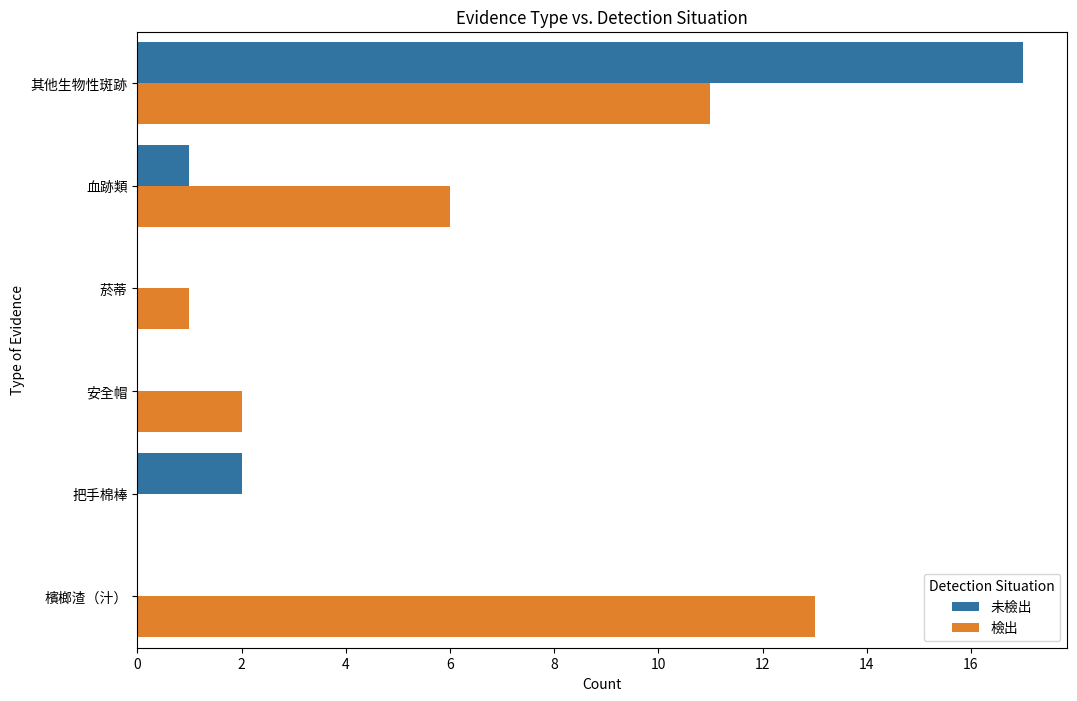

In [7]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm


fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# Extracting relevant columns for analysis: '證物種類' (Type of Evidence) and '檢出情形' (Detection Situation)
# We already have the '未檢出' (Not Detected) column from earlier analysis
evidence_detection_data = merged_quantified_df[['證物種類', '檢出情形']].dropna()
evidence_detection_data['未檢出'] = evidence_detection_data['檢出情形'].apply(lambda x: '未檢出' if '未檢出' in str(x) else '檢出')

# Creating a count plot to visualize the relationship between evidence type and detection situation
plt.figure(figsize=(12, 8))
sns.countplot(y='證物種類', hue='未檢出', data=evidence_detection_data)
plt.title('Evidence Type vs. Detection Situation')
plt.xlabel('Count')
plt.ylabel('Type of Evidence')
plt.legend(title='Detection Situation', loc='best')
plt.show()



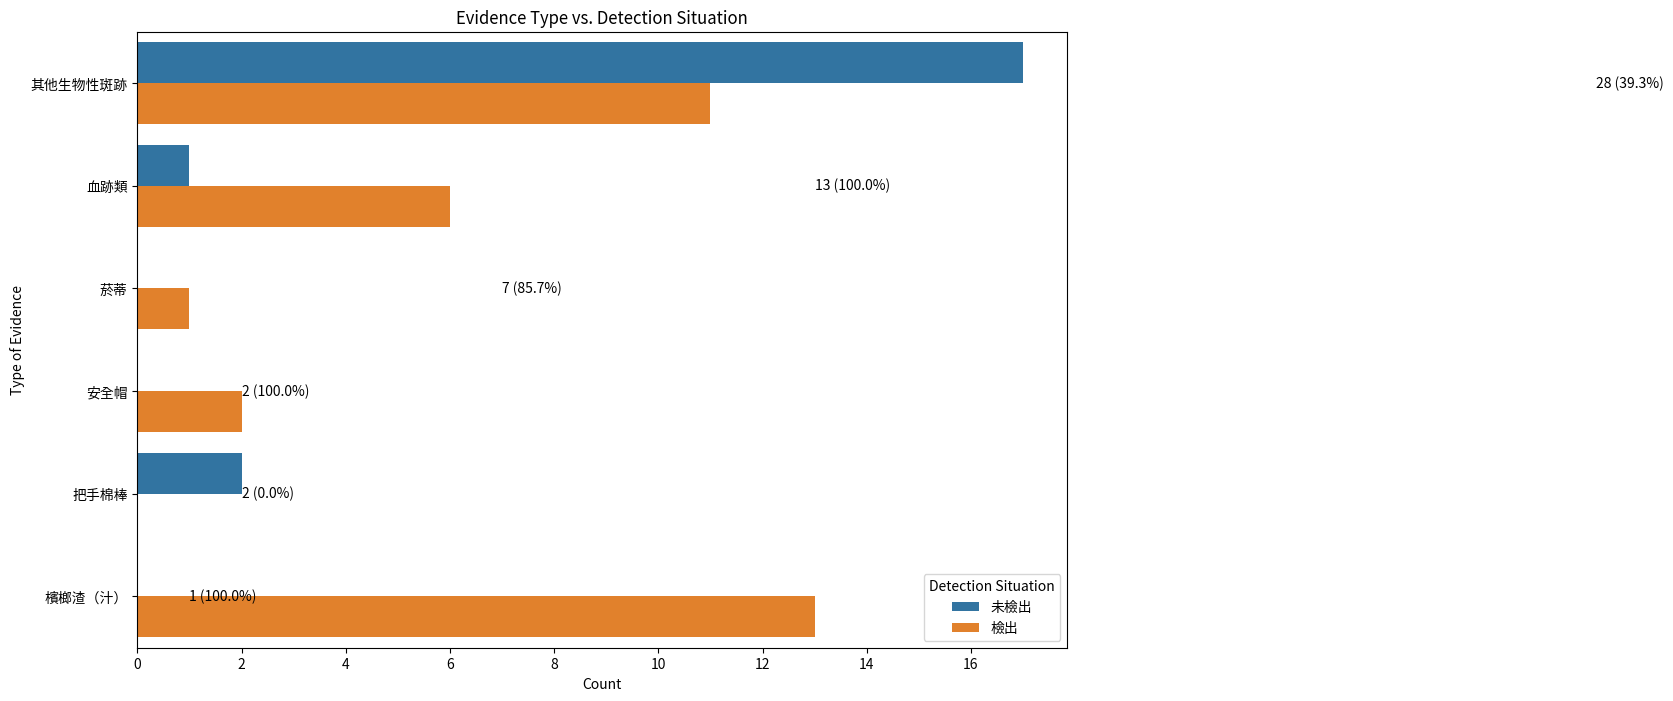

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.font_manager as fm

# 設定字體
fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# 數據處理
evidence_detection_data = merged_quantified_df[['證物種類', '檢出情形']].dropna()
evidence_detection_data['未檢出'] = evidence_detection_data['檢出情形'].apply(lambda x: '未檢出' if '未檢出' in str(x) else '檢出')

# 計算每個證物種類的總數量和檢出數量
total_counts = evidence_detection_data['證物種類'].value_counts()
detected_counts = evidence_detection_data[evidence_detection_data['未檢出'] == '檢出']['證物種類'].value_counts()

# 繪製圖表
plt.figure(figsize=(12, 8))
sns.countplot(y='證物種類', hue='未檢出', data=evidence_detection_data)
plt.title('Evidence Type vs. Detection Situation')
plt.xlabel('Count')
plt.ylabel('Type of Evidence')

# 在圖表上標出數據
for i, evidence_type in enumerate(total_counts.index):
    count = total_counts[evidence_type]
    detected = detected_counts.get(evidence_type, 0)
    percentage = (detected / count) * 100
    plt.text(count, i, f'{count} ({percentage:.1f}%)', va='center')

plt.legend(title='Detection Situation', loc='best')
plt.show()
